# Marketing Analytics Project

### Master's Degree in Data Science (A.Y. 2023/2024)
University of Milano - Bicocca

- Enrico Mannarino (ID 850859)
- Giorgia Prina (ID 858740)

Projects scopes are:

- (CORE) **Analyse** the data context.
- Develop 3 data driven strategies for the aspects:
    - (CORE) **Customer Focus**: prevention of the churn of high value customers by a marketing campaign for customer retention **[CHURN + RFM]**;
    - (CORE) **Product Focus**: Increase the profit by a marketing campaign for product cross-selling **[MBA]**;
    - (CORE) **Feedback Focus**: Address detractor and promoter customers with a loyal engagement marketing campaign to reduce the negative impact of detractors and to incentive the positive effect of promoters **[SENTIMENT ANALYSIS]**.

Available tables:
- **Addresses** (info on address corresponding to a customer account)
- **Customer accounts** (info on the loyalty account associated to the customers)
- **Customer reviews** (the reviews made by the customers)
- **Customers** (info on the customers)
- **Labelled reviews** (a set of review texts with the sentiment labels assigned (ground truth))
- **Orders** (all the orders made by the customers, i.e. all the products purchased or refunded by the customers)
- **Products** (the info on the products)

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = [15,8]

# Data preparation and overview

## Customers data

In [2]:
customers = pd.read_csv("tbl_customers.csv")
customers

,customer_id,address_id,birthdate,gender,job_type,email_provider,flag_phone_provided,flag_privacy
0,891057,863914,2001-10-22,F,NaN,yahoo.it,1.0,True
1,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False
2,514958,494806,2001-01-01,M,NaN,libero.it,1.0,True
3,398355,377261,2000-03-09,M,NaN,gmail.com,1.0,True
4,23808,20227,1999-11-21,F,NaN,virgilio.it,1.0,True
...,...,...,...,...,...,...,...,...
140941,449222,428121,1945-05-30,F,NaN,libero.it,1.0,True
140942,368113,346970,1943-11-18,F,NaN,yahoo.com,1.0,True
140943,424451,403292,1943-05-07,F,NaN,gmail.com,1.0,True
140944,808137,789737,1943-02-13,F,NaN,yahoo.it,1.0,True


In [3]:
customers.shape

(140946, 8)

In [4]:
len(customers["customer_id"].unique())

140946

The customers dataset contains no repetitions as the IDs are unique.

In [5]:
missing_values_customers = customers.isnull().sum()
missing_values_customers

customer_id                 0
address_id                  0
birthdate                   0
gender                      0
job_type               136651
email_provider           1835
flag_phone_provided     11271
flag_privacy                0
dtype: int64

Note that only the variables 'job_type', 'email_provider' and 'flag_phone_provider' have missing values. In particular, we can calculate the percentage of the total for each variable.

In [6]:
jt_null = round(136651/140946, 3)
ep_null = round(1835/140946, 3)
fp_null = round(11271/140946, 3)
print(f"Number of:\n Null job type: {jt_null}\n Null email: {ep_null}\n Null phone: {fp_null}")

Number of:
 Null job type: 0.97
 Null email: 0.013
 Null phone: 0.08


We note that the majority of customers did not provide information on their profession (about 97%). On the contrary, probably for reasons of registering on the site or receiving information such as a purchase receipt or shipping information, relatively few consumers decided not to provide an e-mail or telephone number.

However, since for the purposes of our analysis the mentioned variables are irrelevant, we exclude them:

In [7]:
customers = customers.drop(['job_type', 'email_provider', 'flag_phone_provided'], axis = 1)

### Age distribution

In [8]:
customers['birthdate'] = pd.to_datetime(customers['birthdate'], format='%Y-%m-%d')
customers[['birthdate']] # we corrected the format in 'datetime' type for the date of birth of customers

,birthdate
0,2001-10-22
1,2001-04-30
2,2001-01-01
3,2000-03-09
4,1999-11-21
...,...
140941,1945-05-30
140942,1943-11-18
140943,1943-05-07
140944,1943-02-13


Since the dataset only provides the date of birth, let us try to calculate the age. We keep the time range as the one in which the dataset was received, i.e. we calculate the years from date of birth to 30 April 2023.

In [9]:
customers['age'] = (pd.to_datetime('2023-04-30') - customers['birthdate']).astype('<m8[Y]').astype(int)
customers[['age']] # create a new variable in which we have the age

,age
0,21
1,21
2,22
3,23
4,23
...,...
140941,77
140942,79
140943,79
140944,80


In addition, we decide to create 7 age classes (labels) to group customers in order to better visualise the distribution:

In [10]:
intervals = [0, 17, 24, 34, 44, 54, 64, float('inf')]
labels = ['0-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

customers['age_interval'] = pd.cut(customers['age'], bins=intervals, labels=labels)
customers[['age_interval']] # create another variable in which we define the age range

,age_interval
0,18-24
1,18-24
2,18-24
3,18-24
4,18-24
...,...
140941,65+
140942,65+
140943,65+
140944,65+


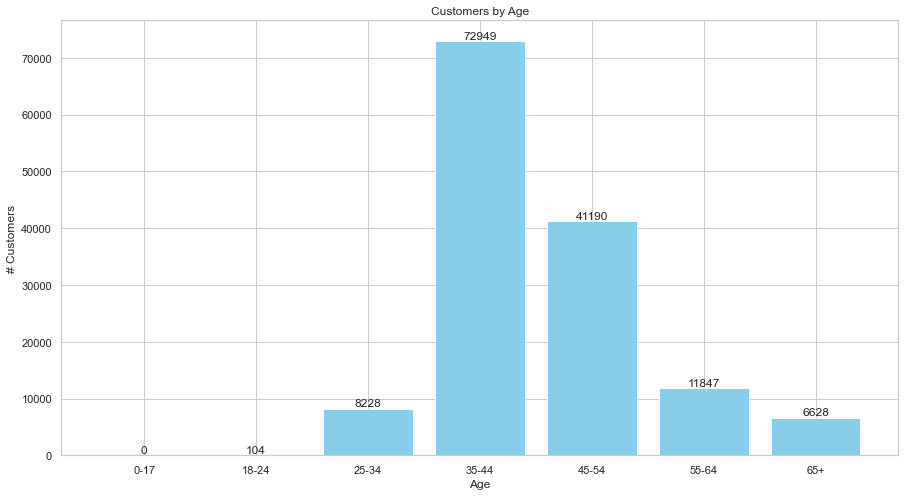

In [103]:
class_frequencies = customers['age_interval'].value_counts().reindex(labels, fill_value=0)

bars = plt.bar(class_frequencies.index, class_frequencies, color='skyblue')
plt.xlabel('Age')
plt.ylabel('# Customers')
plt.title('Customers by Age')

for bar, tot in zip(bars, class_frequencies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), tot,
             ha='center', va='bottom')
plt.show()

We note that there are no minors, very few users in the 18-24 age group, while the vast majority (81%) are in the 35-54 age range.

### Gender distribution

In [12]:
gender_count = customers['gender'].value_counts()
gender_count

F    72320
M    68626
Name: gender, dtype: int64

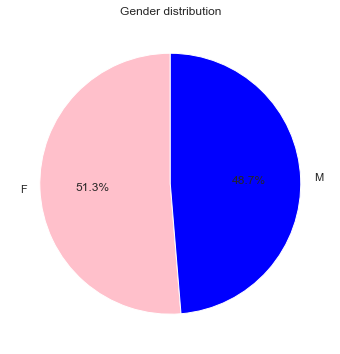

In [105]:
plt.pie(gender_count, labels=gender_count.index, autopct='%1.1f%%', startangle=90, colors=['pink', 'blue'])
plt.title('Gender distribution')
plt.show()

As we can deduce from the graphical representation, the gender distribution is homogeneous, the number of women and men almost reaching parity.

### Geo distribution (Addresses data)

In [14]:
addresses =  pd.read_csv("tbl_addresses.csv", dtype={'postal_code': str})
addresses 

,address_id,postal_code,district,region
0,1337,20083,MI,LOMBARDIA
1,1347,20090,MI,LOMBARDIA
2,1347,20090,MI,LOMBARDIA
3,1347,20090,MI,LOMBARDIA
4,1347,20090,MI,LOMBARDIA
...,...,...,...,...
245420,34811,40011,BO,EMILIA ROMAGNA
245421,651219,35030,PD,VENETO
245422,570394,47924,RN,EMILIA ROMAGNA
245423,670325,84030,SA,CAMPANIA


In [15]:
addresses.shape

(245425, 4)

In [16]:
len(addresses["address_id"].unique())

157765

We note that some IDs are repeated. This is due to the fact that the table considers the combination postal_code, district and region, and therefore it is possible that several districts in the same region have the same postal_code as their identifier. In fact, remember that the postal_code does not really identify a municipality but a geographical area that may contain several municipalities or parts of several municipalities.

Let us now perform a further exploratory analysis to check the correctness of the fields and normalise as well as clean up the data in each column:

In [17]:
addresses['region'] = addresses['region'].str.lower().str.replace('-', ' ') 
# Put everything in lower case and remove '-' where present (Trentino) in order to integrate with the other dataset

In [18]:
missing_values_addresses = addresses.isnull().sum() # missing values for POSTAL_CODE, DISTRICT and REGION variables
missing_values_addresses

address_id         0
postal_code       49
district       19066
region          6746
dtype: int64

In [19]:
pc_null = round(49/245425, 3)
ds_null = round(19066/245425, 3)
rg_null = round(6746/245425, 3)
print(f"Number of:\n Null postal code: {pc_null}\n Null district: {ds_null}\n Null region: {rg_null}")

Number of:
 Null postal code: 0.0
 Null district: 0.078
 Null region: 0.027


From an initial visualisation of the data in the **tbl_addresses** table, we do not notice a strong presence of null values, in particular the variable 'postal_code' has a percentage of null values similar to zero. We note, however, the presence of inconsistencies between the postcodes and their respective regions. Since we want to analyse the number of customers per region, we proceed with the cleaning of the reference data by taking the postcodes as reference, without considering other anomalies (e.g. column of provinces).

We try to correct the postcodes, provinces and regions using an **external dataset** that contains information on each Italian municipality and their respective provinces and regions.

In [20]:
comuni_tab = pd.read_csv("gi_comuni_cap.csv", dtype={'cap': str}, delimiter=';')
comuni_tab['denominazione_regione'] = comuni_tab['denominazione_regione'].str.lower().str.replace('-', ' ')
comuni_tab.shape

(8463, 17)

In [21]:
comuni_tab

,codice_istat,denominazione_ita_altra,denominazione_ita,denominazione_altra,cap,sigla_provincia,denominazione_provincia,tipologia_provincia,codice_regione,denominazione_regione,tipologia_regione,ripartizione_geografica,flag_capoluogo,codice_belfiore,lat,lon,superficie_kmq
0,1001,Agliè,Agliè,NaN,10011,TO,Torino,Citta metropolitana,1,piemonte,statuto ordinario,Nord-ovest,NO,A074,"45,3634368","7,7685999","13,1462"
1,1002,Airasca,Airasca,NaN,10060,TO,Torino,Citta metropolitana,1,piemonte,statuto ordinario,Nord-ovest,NO,A109,"44,9168832","7,4844311","15,7393"
2,1003,Ala di Stura,Ala di Stura,NaN,10070,TO,Torino,Citta metropolitana,1,piemonte,statuto ordinario,Nord-ovest,NO,A117,"45,3151133","7,3043438","46,3315"
3,1004,Albiano d'Ivrea,Albiano d'Ivrea,NaN,10010,TO,Torino,Citta metropolitana,1,piemonte,statuto ordinario,Nord-ovest,NO,A157,"45,4338982","7,9491448","11,7314"
4,1006,Almese,Almese,NaN,10040,TO,Torino,Citta metropolitana,1,piemonte,statuto ordinario,Nord-ovest,NO,A218,"45,1176634","7,3951819","17,8756"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8458,111103,Villaputzu,Villaputzu,NaN,09040,SU,Sud Sardegna,Provincia,20,sardegna,statuto speciale,Isole,NO,L998,"39,5346598","9,5514436","181,3074"
8459,111104,Villasalto,Villasalto,NaN,09040,SU,Sud Sardegna,Provincia,20,sardegna,statuto speciale,Isole,NO,M016,"39,4680466","9,3941121","130,3596"
8460,111105,Villasimius,Villasimius,NaN,09049,SU,Sud Sardegna,Provincia,20,sardegna,statuto speciale,Isole,NO,B738,"39,1550781","9,5099547","57,9708"
8461,111106,Villasor,Villasor,NaN,09034,SU,Sud Sardegna,Provincia,20,sardegna,statuto speciale,Isole,NO,M025,"39,3833349","8,9108004","86,7935"


In [22]:
cap_reg = comuni_tab[['cap', 'denominazione_regione']]
cap_reg_df = cap_reg.drop_duplicates()
cap_reg_df

,cap,denominazione_regione
0,10011,piemonte
1,10060,piemonte
2,10070,piemonte
3,10010,piemonte
4,10040,piemonte
...,...,...
8444,09019,sardegna
8451,09039,sardegna
8454,09066,sardegna
8460,09049,sardegna


Let us proceed with the merging of the datasets in order to correct any errors or complete null fields correctly. Since the "postal_code" column in our dataset is complete, i.e. we have no missing values, we decided to use it as the key to perform the merge. We also create a new attribute "merged_region" (only later renamed to "region") that will associate each cap with the correct region. We had previously noticed that in some cases the cap did not reflect the region, in this case we have remedied the problem by inserting data from a reliable external dataset.

In [23]:
result = pd.merge(addresses.drop('district', axis = 1).drop_duplicates(), cap_reg_df, left_on='postal_code', right_on='cap', how='left')
result['merged_region'] = result['denominazione_regione'].fillna(result['region'])
result['merged_region'] = result['merged_region'].str.split('/').str[0]
result = result.drop(['cap', 'region', 'denominazione_regione'], axis = 1)
result = result.rename(columns={'merged_region':'region'})

In [24]:
result

,address_id,postal_code,region
0,1337,20083,lombardia
1,1347,20090,lombardia
2,1387,20084,lombardia
3,1412,20090,lombardia
4,1418,20147,lombardia
...,...,...,...
157761,824736,24040,lombardia
157762,149079,20158,lombardia
157763,484639,95100,sicilia
157764,651219,35030,veneto


Finally, we make a final union between the dataframe relating to customers and that relating to regional caps and designations:

In [25]:
customers_addr = pd.merge(customers, result, on='address_id', how='left')
customers_addr

,customer_id,address_id,birthdate,gender,flag_privacy,age,age_interval,postal_code,region
0,891057,863914,2001-10-22,F,True,21,18-24,10035,piemonte
1,655484,639856,2001-04-30,M,False,21,18-24,71010,puglia
2,514958,494806,2001-01-01,M,True,22,18-24,00042,lazio
3,398355,377261,2000-03-09,M,True,23,18-24,36050,veneto
4,23808,20227,1999-11-21,F,True,23,18-24,60041,marche
...,...,...,...,...,...,...,...,...,...
140941,449222,428121,1945-05-30,F,True,77,65+,47121,emilia romagna
140942,368113,346970,1943-11-18,F,True,79,65+,20135,lombardia
140943,424451,403292,1943-05-07,F,True,79,65+,20154,lombardia
140944,808137,789737,1943-02-13,F,True,80,65+,73022,puglia


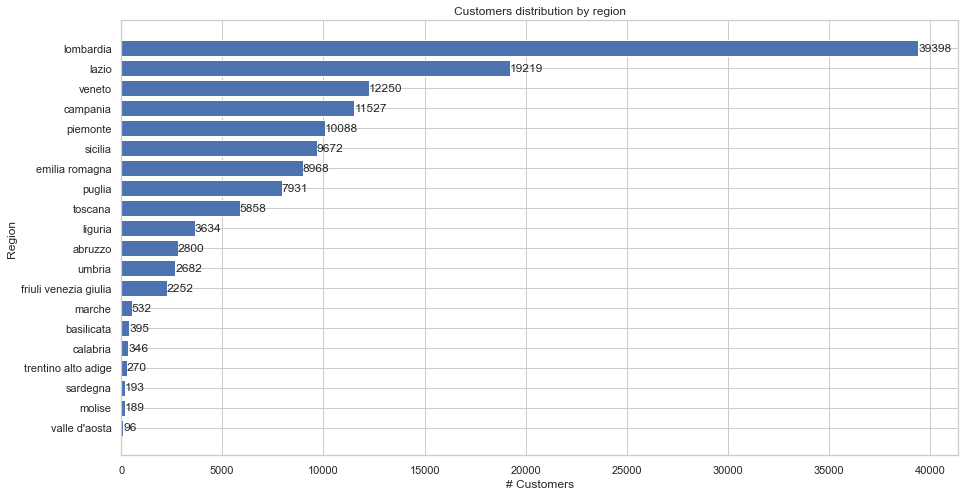

In [106]:
region_counts = customers_addr['region'].value_counts().sort_values(ascending = True)

fig, ax = plt.subplots()
bars = ax.barh(region_counts.index, region_counts)

plt.xlabel('# Customers')
plt.ylabel('Region')
plt.title('Customers distribution by region')

for bar, count in zip(bars, region_counts):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(count), ha='left', va='center')

plt.show()

In [27]:
lombardia = round(39398/140946, 3)
lazio = round(19219/140946, 3)
print(f"clienti lombardia: {lombardia}\nclienti lazio: {lazio}")

clienti lombardia: 0.28
clienti lazio: 0.136


Most customers come from Lombardia (28%) and Lazio (13.6%).

## Products/Orders data

In [28]:
products = pd.read_csv("tbl_products.csv")
products # no missing values

,product_id,product_class
0,35996051,9
1,35980371,14
2,31276196,4
3,31276224,4
4,31456495,4
...,...,...
88533,36218763,3
88534,36219624,3
88535,36219631,3
88536,36219694,3


In [29]:
products[products.duplicated()] # no duplicated rows

,product_id,product_class


In [30]:
products['product_class'] = products['product_class'].astype('str') # to string

In [31]:
orders =  pd.read_csv("tbl_orders.csv")
orders

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,1,125.40,0.0,2022-10-04T182851
1,8fe4346b53d0c781b275a614175804de,23,49,30344384,1,8.30,0.0,2022-10-04T182851
2,8fe4346b53d0c781b275a614175804de,23,49,33794292,1,1.99,0.0,2022-10-04T182851
3,8fe4346b53d0c781b275a614175804de,23,49,33795776,1,5.10,0.0,2022-10-04T182851
4,8fe4346b53d0c781b275a614175804de,23,49,36235381,1,76.05,0.0,2022-10-04T182851
...,...,...,...,...,...,...,...,...
1039860,697c0078b69d9f8c119d8dd9a7952019,934581,29,35508942,1,33.60,0.0,2023-04-30T193553
1039861,86c9c4fdb8829e2ab90a86a357763419,934620,44,36237691,1,11.99,0.0,2023-04-30T191955
1039862,86c9c4fdb8829e2ab90a86a357763419,934620,44,81259479,1,9.99,0.0,2023-04-30T191955
1039863,86f8ca9e4008249e5e0acc5ff23e2284,934660,46,34067775,1,1.90,0.0,2023-04-30T193217


In the 'orders' dataset, we have 8 variables and 1039865 instances. We start by checking the data type of each.

In [32]:
orders['purchase_datetime'] = pd.to_datetime(orders['purchase_datetime'])
orders['purchase_datetime'] # to date format conversion

0         2022-10-04 18:28:51
1         2022-10-04 18:28:51
2         2022-10-04 18:28:51
3         2022-10-04 18:28:51
4         2022-10-04 18:28:51
                  ...        
1039860   2023-04-30 19:35:53
1039861   2023-04-30 19:19:55
1039862   2023-04-30 19:19:55
1039863   2023-04-30 19:32:17
1039864   2023-04-30 20:26:41
Name: purchase_datetime, Length: 1039865, dtype: datetime64[ns]

In the available dataset, the order dates range from 1 May 2022 to 30 April 2023.

In [33]:
missing_values_orders = orders.isnull().sum()
missing_values_orders # no missing values

order_id             0
customer_id          0
store_id             0
product_id           0
direction            0
gross_price          0
price_reduction      0
purchase_datetime    0
dtype: int64

In [34]:
orders[orders.duplicated()] # in this case the duplicates contain information - must not be deleted

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime
18,a55b0fc1b02134f9b5fa4378a74e2e63,23,49,35165452,1,7.47,0.71,2022-11-29 16:26:28
43,2685d6e34e5f26eea7bd6143fa7ed3e4,30,49,48500403,1,1123.54,44.44,2022-07-23 07:06:38
44,2685d6e34e5f26eea7bd6143fa7ed3e4,30,49,48500403,1,1123.54,44.44,2022-07-23 07:06:38
45,2685d6e34e5f26eea7bd6143fa7ed3e4,30,49,48500403,1,1123.54,44.44,2022-07-23 07:06:38
46,2685d6e34e5f26eea7bd6143fa7ed3e4,30,49,48500403,1,1123.54,44.44,2022-07-23 07:06:38
...,...,...,...,...,...,...,...,...
1039808,983342c725b3b280bc36dc93ba92c4e4,934142,45,35196315,1,3.99,0.00,2023-04-30 15:47:25
1039809,983342c725b3b280bc36dc93ba92c4e4,934142,45,35196315,1,3.99,0.00,2023-04-30 15:47:25
1039811,983342c725b3b280bc36dc93ba92c4e4,934142,45,34212010,1,46.90,0.00,2023-04-30 15:47:25
1039834,77746cb9eb0b08d310ee7b3690a30f39,934317,28,35611086,1,8.90,0.00,2023-04-30 17:39:17


Let's now combine the two datasets 'orders' and 'products' so as to obtain the same number of instances of the 'orders' table and place the values of the attributes of the 'products' table alongside them.

In [35]:
ord_prod = pd.merge(orders, products, on = 'product_id', how='left')
ord_prod

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,product_class
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,1,125.40,0.0,2022-10-04 18:28:51,6
1,8fe4346b53d0c781b275a614175804de,23,49,30344384,1,8.30,0.0,2022-10-04 18:28:51,6
2,8fe4346b53d0c781b275a614175804de,23,49,33794292,1,1.99,0.0,2022-10-04 18:28:51,6
3,8fe4346b53d0c781b275a614175804de,23,49,33795776,1,5.10,0.0,2022-10-04 18:28:51,6
4,8fe4346b53d0c781b275a614175804de,23,49,36235381,1,76.05,0.0,2022-10-04 18:28:51,6
...,...,...,...,...,...,...,...,...,...
1039860,697c0078b69d9f8c119d8dd9a7952019,934581,29,35508942,1,33.60,0.0,2023-04-30 19:35:53,2
1039861,86c9c4fdb8829e2ab90a86a357763419,934620,44,36237691,1,11.99,0.0,2023-04-30 19:19:55,13
1039862,86c9c4fdb8829e2ab90a86a357763419,934620,44,81259479,1,9.99,0.0,2023-04-30 19:19:55,13
1039863,86f8ca9e4008249e5e0acc5ff23e2284,934660,46,34067775,1,1.90,0.0,2023-04-30 19:32:17,9


In [36]:
ord_prod.describe()[['direction', 'gross_price', 'price_reduction']]

,direction,gross_price,price_reduction
count,1.039865e+06,1.039865e+06,1.039865e+06
mean,8.796825e-01,2.661887e+01,2.118577e+00
std,4.755618e-01,1.186921e+02,1.639026e+01
min,-1.000000e+00,-1.746500e+04,-2.095800e+03
25%,1.000000e+00,1.850000e+00,0.000000e+00
50%,1.000000e+00,4.990000e+00,0.000000e+00
75%,1.000000e+00,1.499000e+01,0.000000e+00
max,1.000000e+00,1.746500e+04,2.096500e+03


Let us examine more specifically the attributes whose descriptive statistics have meaning, namely 'direction', 'gross_price' and 'price_reduction'. We note that the variable direction is a binary variable indicating the direction of the purchase, i.e. whether it is a purchase (1) or a return (-1). The average is positive and very close to 1, so we can say that most transactions are a purchase. 
With regard to the 'gross_price' we note that the average is 26.61, which means that on average the products purchased by users are priced at 27€. However, in this case the standard deviation is very high, which suggests that the distribution of the data is very wide and heterogeneous. Finally, with regard to 'price_reduction' we can say that the behaviour is similar to 'gross_price' i.e. low mean and high standard deviation.

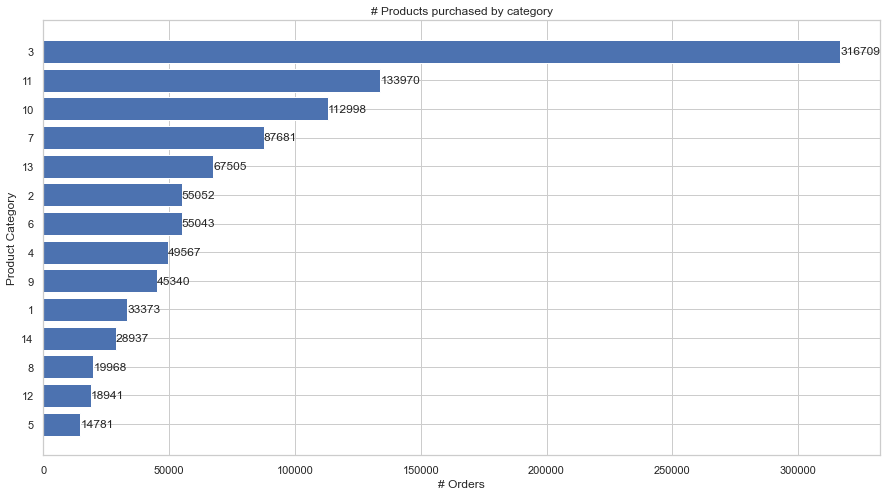

In [108]:
prod_cat_counts = ord_prod['product_class'].value_counts().sort_values(ascending = True)

fig, ax = plt.subplots()
bars = ax.barh(prod_cat_counts.index, prod_cat_counts)

plt.xlabel('# Orders')
plt.ylabel('Product Category')
plt.title('# Products purchased by category')

for bar, count in zip(bars, prod_cat_counts):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(count), ha='left', va='center')

plt.show()

In [38]:
first = round(316709/1039865, 3)
second = round(133970/1039865, 3)
third = round(112998/1039865, 3)

print(f'First: {first}\nSecond: {second}\nThird: {third}')

First: 0.305
Second: 0.129
Third: 0.109


The top 3 best-selling product categories are:
* 3 (30.5%) 
* 11 (12.3%)
* 10 (10.9%)

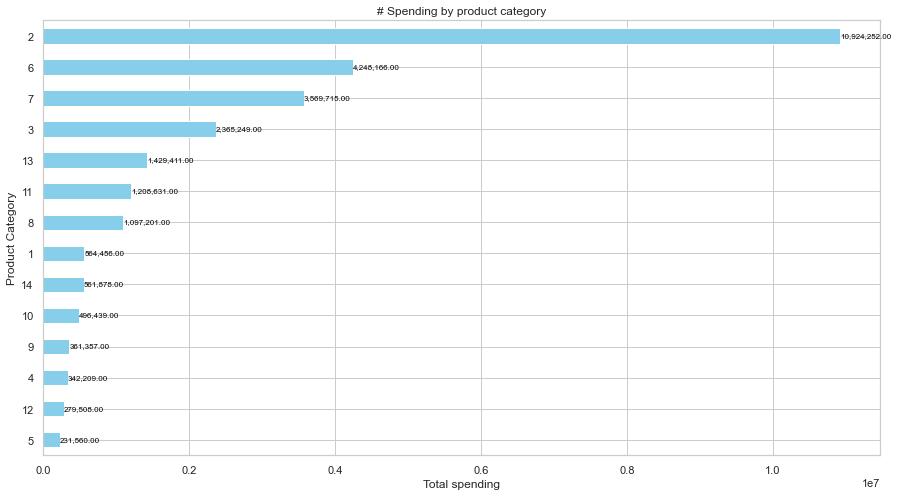

In [109]:
total_sold = ord_prod.groupby('product_class')['gross_price'].sum().sort_values(ascending=True)

bars = round(total_sold).plot(kind='barh', color='skyblue')

for bar in bars.patches:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():,.2f}', 
             va='center', ha='left', fontsize=8, color='black')

plt.title('# Spending by product category')
plt.ylabel('Product Category')
plt.xlabel('Total spending')
plt.show()

We have now calculated the total amount spent on each category and this measure is dependent on both the quantities purchased and the price of the product, so we expect the top 3 listed above to be present in the top positions but not to cover the values at the top again. In fact, the product on which the highest amount of money was spent is number 2 with a value of 10924252.

In [40]:
total_discount = ord_prod.groupby('product_class')['price_reduction'].sum().sort_values(ascending=True)
total_discount

product_class
4        6986.01
1       16035.83
5       18454.84
9       20518.30
14      23265.61
12      23858.22
10      33857.54
11      54816.09
8       55594.96
13      70371.15
3       93019.80
7      212344.75
6      398386.92
2     1175523.65
Name: price_reduction, dtype: float64

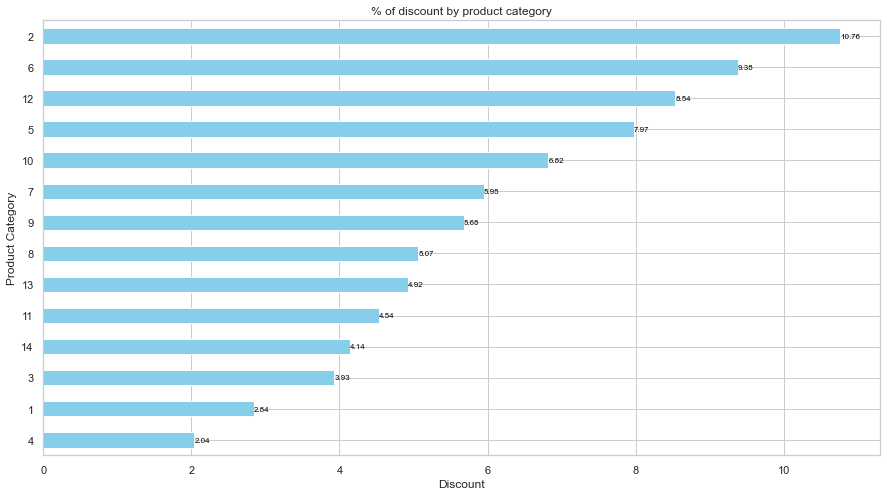

In [110]:
perc_reduction = (total_discount / total_sold) * 100
perc_reduction = perc_reduction.sort_values(ascending = True)


bars = perc_reduction.plot(kind='barh', color='skyblue')

for bar in bars.patches:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():,.2f}', 
             va='center', ha='left', fontsize=8, color='black')

plt.title('% of discount by product category')
plt.ylabel('Product Category')
plt.xlabel('Discount')
plt.show()

Let us now display in order the amount of discount applied for each product. We note that category 2 is still the first in the ranking. This is a calculation in relative values, as we related the total discount to the total amount earned.

## Customer accounts data

In [42]:
customer_accounts = pd.read_csv("tbl_customer_accounts.csv")
customer_accounts

,customer_id,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date
0,9557,746573,9,premium,1,2023-01-11
1,743090,776971,2,premium,1,2023-01-30
2,813156,791681,45,premium,1,2023-02-08
3,843392,825439,1,premium,1,2023-03-01
4,20476,815010,16,premium,1,2023-02-23
...,...,...,...,...,...,...
169489,828458,895971,47,standard,1,2023-04-09
169490,575891,525794,1,standard,1,2022-09-14
169491,316991,231471,14,standard,1,2022-04-15
169492,403638,329448,1,standard,1,2022-05-31


With regard to the types of variables, we note that everything is correct during the import except for the date. Below we change the format from 'object' to 'date':

In [43]:
customer_accounts['activation_date'] = pd.to_datetime(customer_accounts['activation_date'])
customer_accounts['activation_date']

0        2023-01-11
1        2023-01-30
2        2023-02-08
3        2023-03-01
4        2023-02-23
            ...    
169489   2023-04-09
169490   2022-09-14
169491   2022-04-15
169492   2022-05-31
169493   2023-03-09
Name: activation_date, Length: 169494, dtype: datetime64[ns]

In [44]:
missing_values_customer_accounts = customer_accounts.isnull().sum()
missing_values_customer_accounts 

customer_id        0
account_id         0
favorite_store     0
loyalty_type       0
loyatlty_status    0
activation_date    0
dtype: int64

The result shows that there are no missing values.

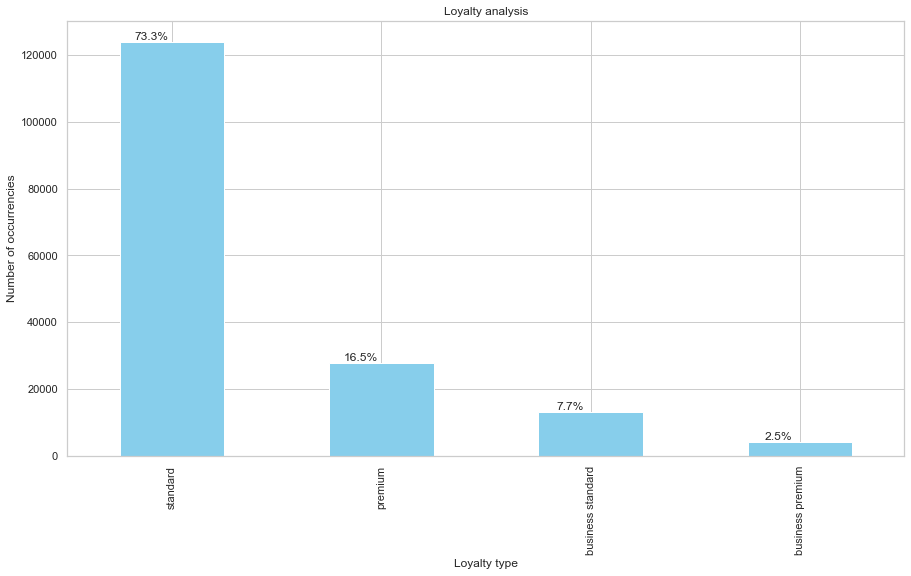

In [111]:
loyalty_occurrencies = customer_accounts['loyalty_type'].value_counts()
loyalty_occurrencies

ax = loyalty_occurrencies.plot(kind='bar', color='skyblue')

total = sum(loyalty_occurrencies)
for i in ax.patches:
    percentage = '{:.1f}%'.format(100 * i.get_height() / total)
    x = i.get_x() + i.get_width() / 2 - 0.1
    y = i.get_height() + 0.5
    ax.text(x, y, percentage, ha='center', va='bottom', fontsize=12)

plt.title('Loyalty analysis')
plt.xlabel('Loyalty type')
plt.ylabel('Number of occurrencies')

plt.show()

As we can see, the majority of customers, i.e. 73.3%, are labelled as 'standard' consumers. Next we find premium customers with a share of 16.5%, then standard business (7.7%) and finally premium business (2.5%). We can guess that most customers are private individuals and only a small percentage are companies (business customers). The two categories are then divided into standard and premium.

In [46]:
customer_accounts[customer_accounts['customer_id'].duplicated(keep=False)]

,customer_id,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date
21,664109,827950,25,premium,1,2023-03-02
38,21750,155594,20,premium,0,2022-03-13
262,179063,273001,22,premium,1,2022-05-05
270,436341,602097,45,premium,1,2022-10-24
523,106937,1007,47,standard,0,2022-01-02
...,...,...,...,...,...,...
148322,91719,608300,1,standard,1,2022-10-27
152035,329917,428659,1,business standard,1,2022-07-23
154785,76490,525128,32,standard,0,2022-09-14
157027,91719,416809,37,standard,0,2022-07-16


We note that in some cases there are duplicate observations in which only the loyalty_type changes, so we delete the duplicates keeping only the first (most recent) observation:

In [47]:
customer_accounts = customer_accounts.drop_duplicates('customer_id')

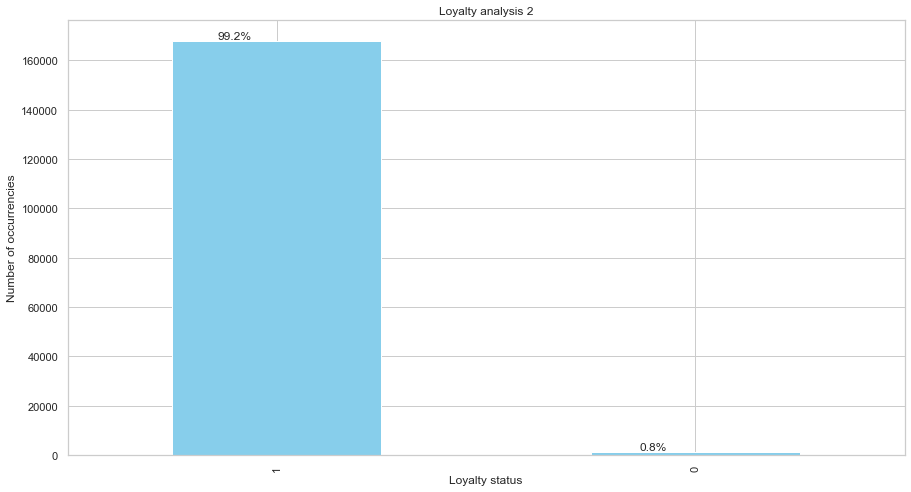

In [114]:
status_occurrencies = customer_accounts['loyatlty_status'].value_counts()
status_occurrencies

ax = status_occurrencies.plot(kind='bar', color='skyblue')

total = sum(status_occurrencies)
for i in ax.patches:
    percentage = '{:.1f}%'.format(100 * i.get_height() / total)
    x = i.get_x() + i.get_width() / 2 - 0.1
    y = i.get_height() + 0.5
    ax.text(x, y, percentage, ha='center', va='bottom', fontsize=12)

plt.title('Loyalty analysis 2')
plt.xlabel('Loyalty status')
plt.ylabel('Number of occurrencies')

plt.show()

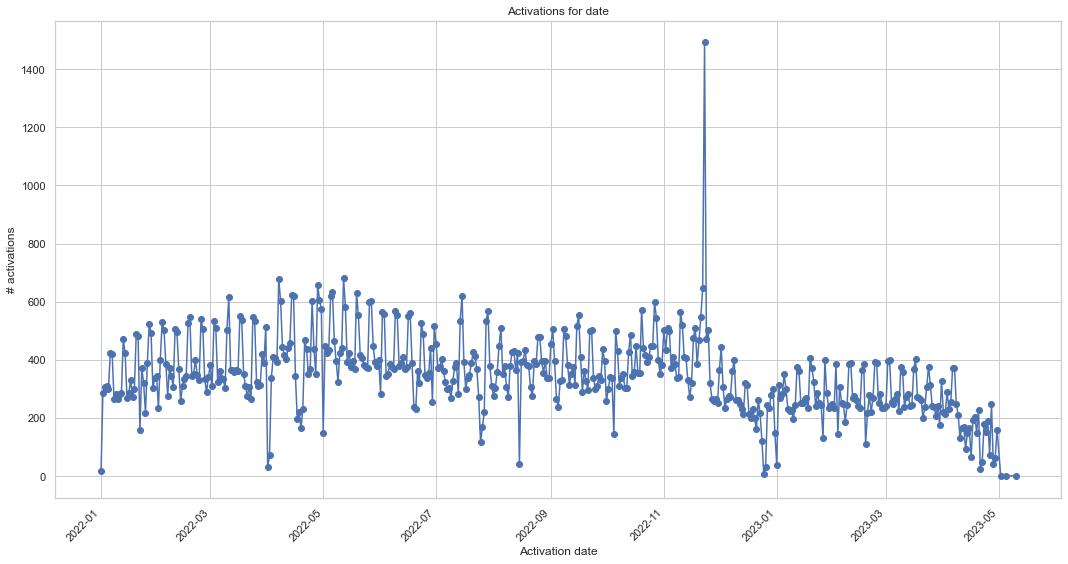

In [113]:
activation_count = customer_accounts['activation_date'].value_counts().sort_index()

activation_count.plot(marker='o', linestyle='-')

plt.title('Activations for date')
plt.xlabel('Activation date')
plt.ylabel('# activations')
plt.grid(True)
plt.xticks(rotation=45)  

plt.tight_layout()
plt.show()

In [50]:
activation_count.max()

1492

In [51]:
result = customer_accounts.groupby('activation_date').size().reset_index(name='count_of_dates')
result_1492 = result[result['count_of_dates'] == 1492]
result_1492

,activation_date,count_of_dates
326,2022-11-23,1492


Prominent in the representation of the number of activations is the date of 23 November 2022, where there seems to have been a boom in registrations for the platform. So much so that 1492 users signed up.

Below we define a new variable consisting of the number of days that have passed since the activation of each customer's account:

In [52]:
customer_accounts['days_from_activation'] = (pd.to_datetime('2023-04-30') - customer_accounts['activation_date']).dt.days

In [53]:
customer_accounts.head()

,customer_id,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date,days_from_activation
0,9557,746573,9,premium,1,2023-01-11,109
1,743090,776971,2,premium,1,2023-01-30,90
2,813156,791681,45,premium,1,2023-02-08,81
3,843392,825439,1,premium,1,2023-03-01,60
4,20476,815010,16,premium,1,2023-02-23,66


## Customer reviews data

In [54]:
customer_reviews = pd.read_csv("tbl_customer_reviews.csv")
customer_reviews

,review_id,customer_id,review_text
0,1,814256,I have bought several of the Vitality canned d...
1,2,457475,Product arrived labeled as Jumbo Salted Peanut...
2,3,104045,This is a confection that has been around a fe...
3,4,603662,If you are looking for the secret ingredient i...
4,5,739314,Great taffy at a great price. There was a wid...
...,...,...,...
105705,140942,224091,"We Love,Love our Keurig coffee maker .My husba..."
105706,140943,196666,This is supposed to be a light roast coffee bu...
105707,140944,618226,I have always been happy with my Kcups but thi...
105708,140945,844918,I ordered light roast coffee and was sent one ...


In this case, we are dealing with a dataset comprising two IDs, a foreign key and a primary key. Unlike the previous datasets, in this case the 'review_text' column contains textual review data on which a sentiment analysis will then be performed.

In [55]:
missing_values_customer_reviews = customer_reviews.isnull().sum()
missing_values_customer_reviews

review_id      0
customer_id    0
review_text    0
dtype: int64

There are no missing values.

In [56]:
customer_reviews['customer_id'].value_counts().reset_index()['customer_id'].nunique() 

1

All present 'Customer_id' appear only once, so nobody wrote more than one review.

Note how in the dataset 'customer_reviews' 1 review is combined with 1 'customer_id'. This means that it is possible that not all customers have left a review and especially that a single customer cannot have left more than one review. For the churn analysis we will use this data by transforming it into a binary to know whether a user has left at least one review.

In [57]:
customer_reviews = customer_reviews.assign(yes_review=1) 
# I create a new variable 'yes_review' with values all equal to 1, useful for identifying those customers
# who have written a review from those who have never done so when joining with other datasets
customer_reviews

,review_id,customer_id,review_text,yes_review
0,1,814256,I have bought several of the Vitality canned d...,1
1,2,457475,Product arrived labeled as Jumbo Salted Peanut...,1
2,3,104045,This is a confection that has been around a fe...,1
3,4,603662,If you are looking for the secret ingredient i...,1
4,5,739314,Great taffy at a great price. There was a wid...,1
...,...,...,...,...
105705,140942,224091,"We Love,Love our Keurig coffee maker .My husba...",1
105706,140943,196666,This is supposed to be a light roast coffee bu...,1
105707,140944,618226,I have always been happy with my Kcups but thi...,1
105708,140945,844918,I ordered light roast coffee and was sent one ...,1


## Labelled reviews data

In [58]:
labelled_reviews = pd.read_csv("tbl_labelled_reviews.csv")
labelled_reviews

,labelled_reviews_index,review_text,sentiment_label
0,0,I'm no bitters expert but I bought it as a gif...,neutral
1,1,"these are probably great in the right drinks, ...",neutral
2,2,I sent these to my dad for his bday and he sai...,positive
3,3,I purchased these as a gift for family member ...,positive
4,4,My wife bought me this sauce sampler for Chris...,neutral
...,...,...,...
462739,462739,Great for sesame chicken..this is a good if no...,positive
462740,462740,I'm disappointed with the flavor. The chocolat...,neutral
462741,462741,"These stars are small, so you can give 10-15 o...",positive
462742,462742,These are the BEST treats for training and rew...,positive


The dataset has a primary key (labelled_reviews_index), a second attribute containing text relating to customer reviews and a third attribute representing the sentiment of the text (positive, neutral or negative).

We check whether null values exist and then how the reviews are distributed:

In [59]:
missing_values_labelled_reviews = labelled_reviews.isnull().sum()
missing_values_labelled_reviews

labelled_reviews_index    0
review_text               0
sentiment_label           0
dtype: int64

There are no missing values.

In [60]:
sentiment_occurrencies = labelled_reviews['sentiment_label'].value_counts()
sentiment_occurrencies

positive    297008
neutral     123386
negative     42350
Name: sentiment_label, dtype: int64

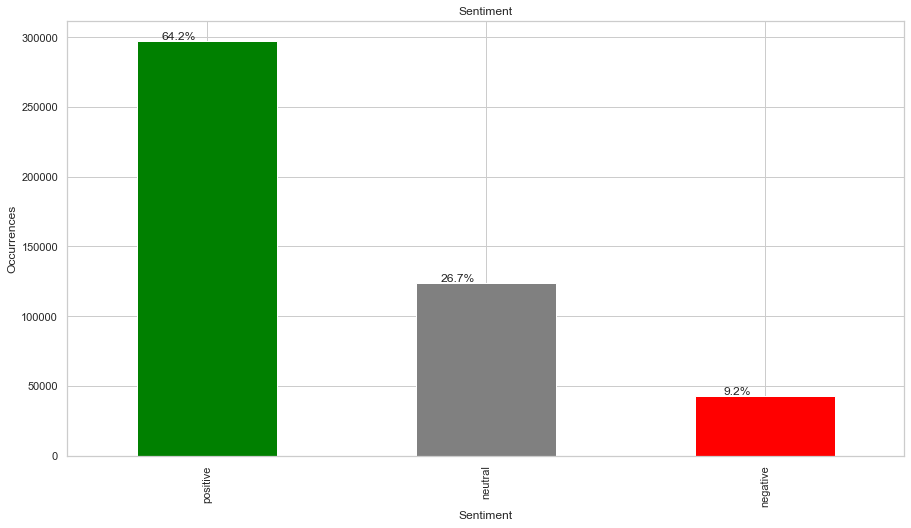

In [115]:
ax = sentiment_occurrencies.plot(kind='bar', color=['green', 'gray', 'red'])

total = sum(sentiment_occurrencies)
for i in ax.patches:
    percentage = '{:.1f}%'.format(100 * i.get_height() / total)
    x = i.get_x() + i.get_width() / 2 - 0.1
    y = i.get_height() + 0.5
    ax.text(x, y, percentage, ha='center', va='bottom', fontsize=12)

plt.title('Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Occurrences')

plt.show()

Most of the reviews were positive, in fact 64.2% of the consumers left a positive review (more than half), 26.7% left a neutral review while only a group of 9.2% of the sample left a negative review.

# RFM Model

RFM (Recency, Frequency, Monetary) is a customer behaviour analysis model used in the field of marketing and sales to segment customers according to their historical behaviour. It is based on three main dimensions:

1. **Recency**: assesses how long it has been since a customer last interacted with a company. Customers who have interacted recently tend to be more engaged and potentially more likely to make further purchases.


2. **Frequency**: represents the number of interactions or purchases made by a customer in a given time period. Customers who make frequent purchases may be considered more loyal or engaged.


3. **Monetary**: Indicates the total amount spent by a customer in the given time period. Customers who spend more may be more profitable for the company.


RFM analysis is usually performed by assigning each of the three dimensions a numerical score based on customer behaviour. These scores are then combined to obtain distinct customer segments, e.g. identifying the most valuable customers (e.g. those with high purchase frequency, large recent spending and frequent interactions).

We start by merging the previous datasets, selecting only those necessary for our analysis, namely the 'orders' dataset and the 'customers' dataset.

In [62]:
ord_cust = pd.merge(orders, customers, on = 'customer_id', how='left')
ord_cust

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,address_id,birthdate,gender,flag_privacy,age,age_interval
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,1,125.40,0.0,2022-10-04 18:28:51,21,1978-08-14,F,True,44,35-44
1,8fe4346b53d0c781b275a614175804de,23,49,30344384,1,8.30,0.0,2022-10-04 18:28:51,21,1978-08-14,F,True,44,35-44
2,8fe4346b53d0c781b275a614175804de,23,49,33794292,1,1.99,0.0,2022-10-04 18:28:51,21,1978-08-14,F,True,44,35-44
3,8fe4346b53d0c781b275a614175804de,23,49,33795776,1,5.10,0.0,2022-10-04 18:28:51,21,1978-08-14,F,True,44,35-44
4,8fe4346b53d0c781b275a614175804de,23,49,36235381,1,76.05,0.0,2022-10-04 18:28:51,21,1978-08-14,F,True,44,35-44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039860,697c0078b69d9f8c119d8dd9a7952019,934581,29,35508942,1,33.60,0.0,2023-04-30 19:35:53,899757,1979-09-28,M,True,43,35-44
1039861,86c9c4fdb8829e2ab90a86a357763419,934620,44,36237691,1,11.99,0.0,2023-04-30 19:19:55,899796,1964-01-29,F,True,59,55-64
1039862,86c9c4fdb8829e2ab90a86a357763419,934620,44,81259479,1,9.99,0.0,2023-04-30 19:19:55,899796,1964-01-29,F,True,59,55-64
1039863,86f8ca9e4008249e5e0acc5ff23e2284,934660,46,34067775,1,1.90,0.0,2023-04-30 19:32:17,899836,1979-05-18,F,True,43,35-44


We have data on the returns made by each user. As this information may be relevant in the following analyses we create a new binary instance 'yes_refund' which will have value 1 if the customer has ever made a return and value 0 if he/she has never made one.

In [63]:
result_direction = ord_cust.groupby('customer_id')['direction'].apply(lambda x: 0 if -1 not in x.values else 1).reset_index(name='yes_refund')
result_direction # 0 if the customer has never made a refund, 1 otherwise

,customer_id,yes_refund
0,23,1
1,30,0
2,32,0
3,48,1
4,50,0
...,...,...
104129,934484,0
104130,934581,0
104131,934620,0
104132,934660,0


For more accurate information in terms of returns and purchases made, we display these values in the following tables:

In [64]:
# Return
returns = ord_cust[ord_cust['direction'] == -1]
unique_returns = returns.drop_duplicates(subset=['customer_id', 'product_id'])
returns_per_customer = unique_returns.groupby('customer_id').size().reset_index(name='total_returns')

# Purchases
purchases = ord_cust[ord_cust['direction'] == 1]
purchases_per_customer = purchases.groupby('customer_id').size().reset_index(name='total_purchases')

combined_df = purchases_per_customer.merge(returns_per_customer, on='customer_id', how='outer').fillna(0)

combined_df

,customer_id,total_purchases,total_returns
0,23,37,2.0
1,30,12,0.0
2,32,11,0.0
3,48,52,16.0
4,50,4,0.0
...,...,...,...
104129,934484,5,0.0
104130,934581,1,0.0
104131,934620,2,0.0
104132,934660,1,0.0


We counted how many purchases each customer made (variable 'total_purchase') and then counted how many returns each customer made (variable 'total_returns'). This second variable was calculated taking into account the customer ID and the product ID. In fact, it may happen that some products are returned several times or in several instalments, or that they are not returned for the full amount for which they were purchased. To overcome this problem, we selected each customer and for each product assessed whether there was at least one -1 direction and considered it a single return. In the event that we found more than one -1 direction for the same product purchased once, we considered the block to be 1 single return.

In [65]:
print(f"Number of active customers: {ord_cust['customer_id'].nunique()}") 
print(f"Number of inactive customers: {len(customers) - ord_cust['customer_id'].nunique()}") 

Number of active customers: 104134
Number of inactive customers: 36812


Shown above is the total number of inactive customers, i.e. those who did not place an order. This is 36812 customers out of 140946 (26.1%). We will not consider them in the analyses to follow (RFM, Churn prediction and so on).

In [66]:
rfm_df = ord_cust.groupby('customer_id').agg({
    'purchase_datetime': lambda x: (ord_cust['purchase_datetime'].max() - x.max()).days, # Recency
    'order_id': 'nunique', # Frequency
    'gross_price': 'sum'   # Monetary
}).reset_index()

rfm_df.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']
rfm_df

,customer_id,Recency,Frequency,Monetary
0,23,69,8,483.51
1,30,281,2,10179.56
2,32,28,3,58.85
3,48,0,20,1053.62
4,50,70,2,28.75
...,...,...,...,...
104129,934484,0,1,39.10
104130,934581,0,1,33.60
104131,934620,0,1,21.98
104132,934660,0,1,1.90


A new dataset was created which, for each active customer, takes into account the values of recency (defined as the number of days since the last purchase since the reference period - 30 April 2023), frequency (defined as the number of orders placed during the reference period - 1 May 2022 to 30 April 2023) and monetary (defined as the amount of money spent during the reference period - 1 May 2022 to 30 April 2023).

I only select the 3 variables to display their distribution:

In [67]:
last_three_columns = rfm_df.iloc[:, -3:]
last_three_columns.describe()

,Recency,Frequency,Monetary
count,104134.000000,104134.000000,104134.000000
mean,130.089250,3.570438,265.811673
std,100.721889,3.538152,2415.383648
min,0.000000,1.000000,-24923.930000
25%,42.000000,1.000000,16.852500
50%,109.000000,2.000000,56.700000
75%,202.000000,4.000000,180.110000
max,364.000000,51.000000,331303.560000


We have 104134 customers (lines):
- for whom an average of 130 days have passed since the last purchase was made;
- who have purchased on average 3.5 times on the platform in the time period considered;
- who have spent an average of €265.8 per purchase.


We can also note that at least one customer made a purchase on the same date that this database was downloaded, while at least one customer made their last purchase 364 days earlier or had not purchased for a year. The median is 109, which tells us that 50% of the users have not purchased for at least 109 days. 


As regards frequency, we can see that 75% of the customers have purchased 4 times in the year and that there is one customer who has purchased 51 times. 


Lastly, we comment on the monetary: we note that 50% of the population spends €56.7 per order, however a particularly large order was placed that reached a maximum amount of €331303.56.
Monetary is the value that has the highest standard deviation among the 3 when compared to mean and median, meaning that the data is very scattered around the average for this variable.

N.B. some monetary values are negative. There are various reasons for this: it could be simple system errors or refunds due to delivery errors or damaged products.

In [68]:
rfm_df[rfm_df['Monetary'] < 0]['customer_id'].count() # 101 active customers with negative monetary (0.001%)

101

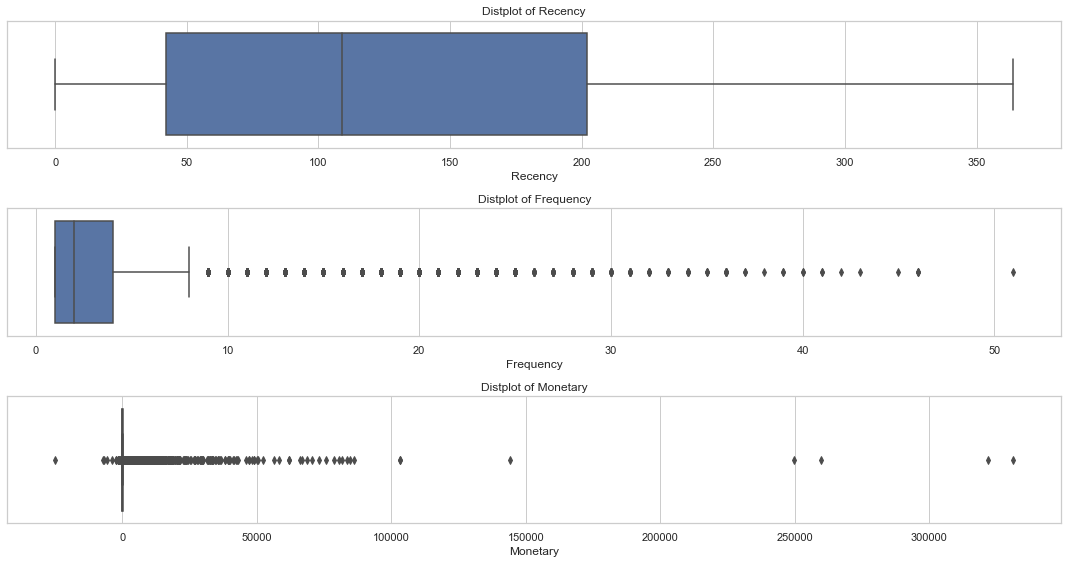

In [116]:
n = 0
for x in ['Recency', 'Frequency', 'Monetary']:
    n += 1
    plt.subplot(3, 1, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    sns.boxplot(rfm_df[x], orient='horizontal')
    plt.title('Distplot of {}'.format(x))
plt.tight_layout()
plt.show()

As we could guess from the descriptive statistics analysis, the recency has a homogeneous distribution, without outliers and with an epicentre shifted to the left, i.e. with a median closer to the minimum value recorded. Frequency has a totally left-shifted distribution, in which the minimum and first quartile coincide and in which there are several particularly scattered values in the fourth quartile. Monetary, on the other hand, presents the highest standard deviation: first and third quartiles are very close.

We decide to proceed with the exclusion of customers with NEGATIVE Monetary values:

In [70]:
rfm_pos = rfm_df.loc[rfm_df['Monetary'] >= 0, :].copy()

## Recency

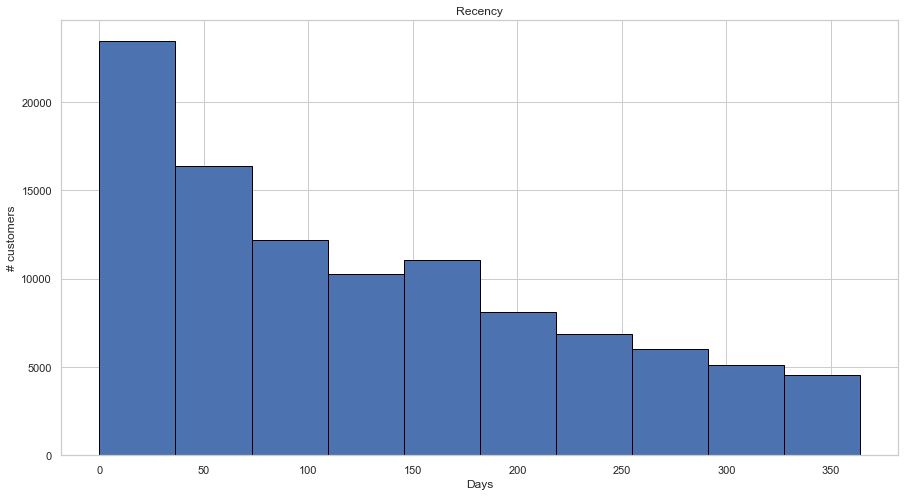

In [117]:
plt.hist(rfm_pos['Recency'], edgecolor='black')

plt.title('Recency')
plt.xlabel('Days')
plt.ylabel('# customers')

plt.show()

Just under 25,000 users have purchased in less than 40 days, which is more or less 25% of the population.

## Frequency

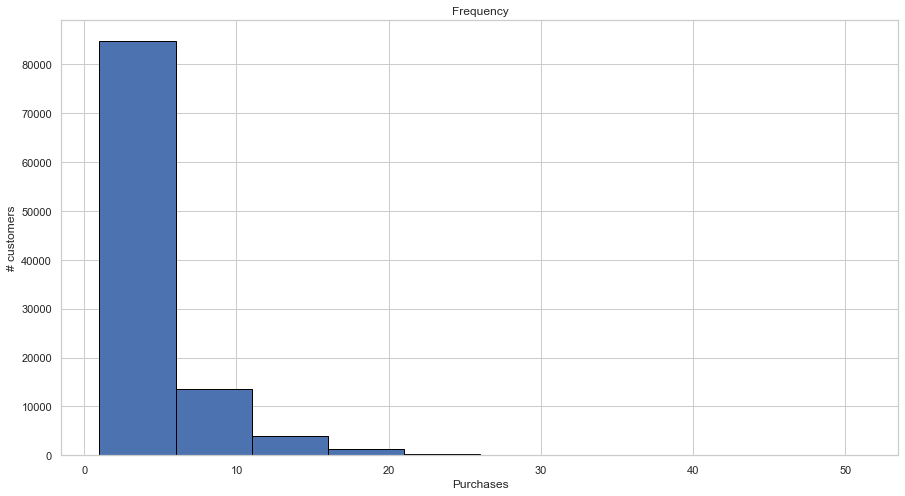

In [118]:
plt.hist(rfm_pos['Frequency'], edgecolor='black')

plt.title('Frequency')
plt.xlabel('Purchases')
plt.ylabel('# customers')

plt.show()

85,000 users made an average of 6 purchases in the time frame considered (1 year), i.e. 80% of customers.

## Monetary

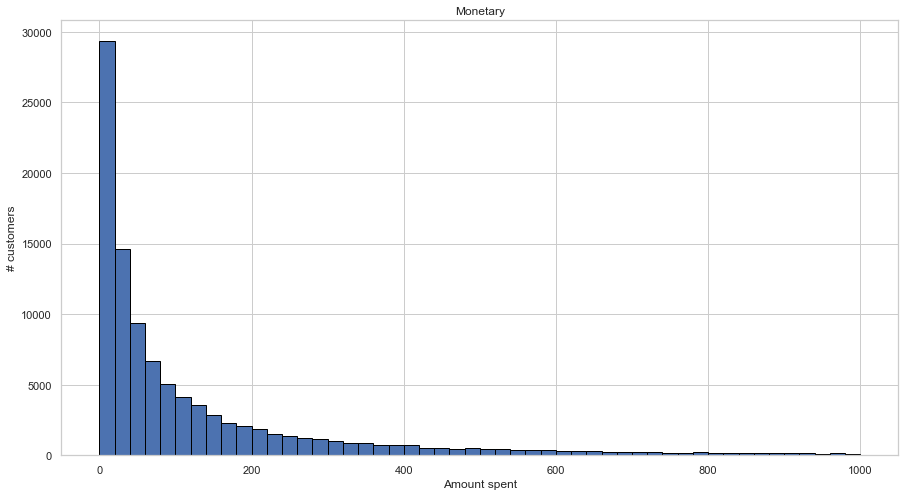

In [119]:
plt.hist(rfm_pos[rfm_pos['Monetary'] < 1000]['Monetary'], bins=50, edgecolor='black')

plt.title('Monetary')
plt.xlabel('Amount spent')
plt.ylabel('# customers')

plt.show()

Just under 30,000 customers spent 20€ on a purchase. That is 28% of the population.

## Segmentation

User segmentation aims to divide a large group of users into smaller, homogeneous subgroups. These segments can be defined according to a number of criteria: in our case, we divide users into three bands for each metric (low, medium and high).

In [74]:
rfm_pos['recency_status'] = pd.qcut(rfm_pos['Recency'], q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')
rfm_pos['frequency_status'] = pd.qcut(rfm_pos['Frequency'], q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')
rfm_pos['monetary_status'] = pd.qcut(rfm_pos['Monetary'], q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')

In [75]:
rfm_pos

,customer_id,Recency,Frequency,Monetary,recency_status,frequency_status,monetary_status
0,23,69,8,483.51,Medium,High,High
1,30,281,2,10179.56,High,Low,High
2,32,28,3,58.85,Low,Medium,Medium
3,48,0,20,1053.62,Low,High,High
4,50,70,2,28.75,Medium,Low,Medium
...,...,...,...,...,...,...,...
104129,934484,0,1,39.10,Low,Low,Medium
104130,934581,0,1,33.60,Low,Low,Medium
104131,934620,0,1,21.98,Low,Low,Low
104132,934660,0,1,1.90,Low,Low,Low


We now assign a unique score to each customer based on how much he or she has been assigned on each metric. There are 7 possible labels: Diamond, Gold, Silver, Bronze, Tin, Copper, Cheap.

In [76]:
def assign_rfm_class(row):

    if ((row['recency_status'] == 'Low' and row['frequency_status'] == 'High' and row['monetary_status'] == 'High')
        or
        (row['recency_status'] == 'Medium' and row['frequency_status'] == 'High' and row['monetary_status'] == 'High')):
        return 'Diamond'

    elif ((row['recency_status'] == 'Low' and row['frequency_status'] == 'High' and row['monetary_status'] == 'Medium')
        or
        (row['recency_status'] == 'Medium' and row['frequency_status'] == 'High' and row['monetary_status'] == 'Medium')
        or
        (row['recency_status'] == 'High' and row['frequency_status'] == 'High' and row['monetary_status'] == 'High')):
        return 'Gold'

    elif ((row['recency_status'] == 'Low' and row['frequency_status'] == 'High' and row['monetary_status'] == 'Low')
        or
        (row['recency_status'] == 'Medium' and row['frequency_status'] == 'High' and row['monetary_status'] == 'Low')
        or
        (row['recency_status'] == 'High' and row['frequency_status'] == 'High' and row['monetary_status'] == 'Medium')
        or
        (row['recency_status'] == 'Low' and row['frequency_status'] == 'Medium' and row['monetary_status'] == 'High')
        or
        (row['recency_status'] == 'Medium' and row['frequency_status'] == 'Medium' and row['monetary_status'] == 'High')):
        return 'Silver'

    elif ((row['recency_status'] == 'Medium' and row['frequency_status'] == 'Medium' and row['monetary_status'] == 'Medium') 
        or 
        (row['recency_status'] == 'High' and row['frequency_status'] == 'Medium' and row['monetary_status'] == 'High') 
        or 
        (row['recency_status'] == 'High' and row['frequency_status'] == 'Low' and row['monetary_status'] == 'High') 
        or 
        (row['recency_status'] == 'High' and row['frequency_status'] == 'High' and row['monetary_status'] == 'Low') 
        or 
        (row['recency_status'] == 'Low' and row['frequency_status'] == 'Medium' and row['monetary_status'] == 'Medium') 
        or 
        (row['recency_status'] == 'Low' and row['frequency_status'] == 'Medium' and row['monetary_status'] == 'Low')):
        return 'Bronze'

    elif ((row['recency_status'] == 'High' and row['frequency_status'] == 'Medium' and row['monetary_status'] == 'Low')
        or 
        (row['recency_status'] == 'High' and row['frequency_status'] == 'Low' and row['monetary_status'] == 'Low') 
        or 
        (row['recency_status'] == 'Medium' and row['frequency_status'] == 'Low' and row['monetary_status'] == 'Medium')
        or 
        (row['recency_status'] == 'Low' and row['frequency_status'] == 'Low' and row['monetary_status'] == 'Medium')):
        return 'Tin'

    elif ((row['recency_status'] == 'Medium' and row['frequency_status'] == 'Low' and row['monetary_status'] == 'Low') 
        or 
        (row['recency_status'] == 'Low' and row['frequency_status'] == 'Low' and row['monetary_status'] == 'Low')):
        return 'Cheap'

    else:
        return 'Copper'

rfm_pos['rfm_class'] = rfm_pos.apply(assign_rfm_class, axis=1)

In [77]:
# Add one-shooter feature for repurchase propensity model analysis
rfm_pos['oneshooter'] = (rfm_pos['Frequency'] == 1).astype(int)

In [78]:
rfm_pos['rfm_class'] = pd.Categorical(rfm_pos['rfm_class'], categories=['Cheap', 'Tin', 'Copper', 'Bronze', 'Silver', 'Gold', 'Diamond'], ordered=True)
rfm_pos['rfm_class'].dtype

CategoricalDtype(categories=['Cheap', 'Tin', 'Copper', 'Bronze', 'Silver', 'Gold',
                  'Diamond'],
, ordered=True)

In [79]:
rfm_pos

,customer_id,Recency,Frequency,Monetary,recency_status,frequency_status,monetary_status,rfm_class,oneshooter
0,23,69,8,483.51,Medium,High,High,Diamond,0
1,30,281,2,10179.56,High,Low,High,Bronze,0
2,32,28,3,58.85,Low,Medium,Medium,Bronze,0
3,48,0,20,1053.62,Low,High,High,Diamond,0
4,50,70,2,28.75,Medium,Low,Medium,Tin,0
...,...,...,...,...,...,...,...,...,...
104129,934484,0,1,39.10,Low,Low,Medium,Tin,1
104130,934581,0,1,33.60,Low,Low,Medium,Tin,1
104131,934620,0,1,21.98,Low,Low,Low,Cheap,1
104132,934660,0,1,1.90,Low,Low,Low,Cheap,1


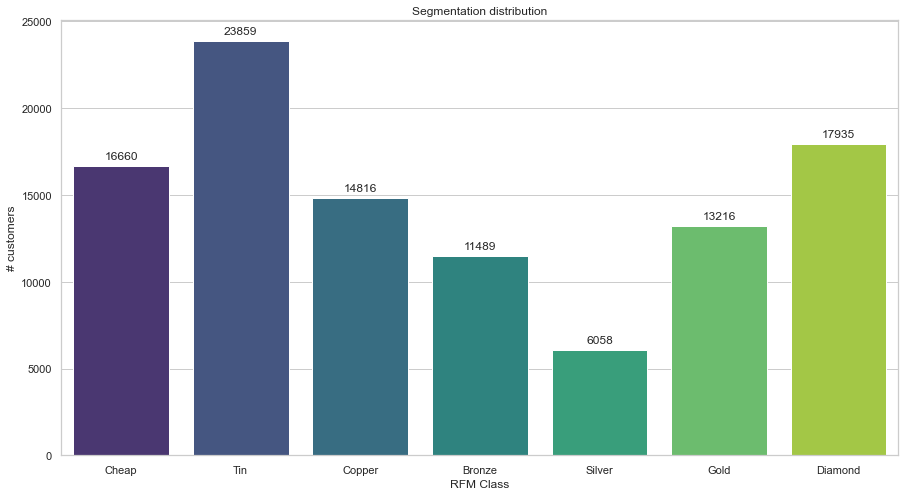

In [120]:
score_distribution = rfm_pos['rfm_class'].value_counts()

ax = sns.countplot(x='rfm_class', data=rfm_pos, palette="viridis")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Segmentation distribution')
plt.xlabel('RFM Class')
plt.ylabel('# customers')
plt.show()

The visualisation shows that most users are in the Tin category. This means that these are users with a low average score for all three metrics. We also note that more than 50 per cent of the users belong to the last four categories in order of importance, i.e. Cheap, Tin, Copper and Bronze. The lowest value was found for the silver category, which represents only 6.8% of the users.

Proceeding with the construction of the curve identifying *'customers by days of purchase'*, we noticed that there are cases where different orders are executed at the same time (purchase_datetime), so considering only the date as an identifier instead of order ID would be wrong.

In [81]:
tab = orders[['customer_id', 'order_id', 'purchase_datetime']].drop_duplicates().sort_values(by=['customer_id', 'purchase_datetime'])

acquisti_con_differenza_giorni = tab.assign(
    previous_purchase_datetime=tab.groupby('customer_id')['purchase_datetime'].shift(1),
    difference_in_days=lambda x: (x['purchase_datetime'] - x['previous_purchase_datetime']).dt.days
)

acquisti_con_differenza_giorni = acquisti_con_differenza_giorni.dropna(subset=['previous_purchase_datetime'])
result = acquisti_con_differenza_giorni.groupby('customer_id')['difference_in_days'].mean().reset_index()
result.columns = ['customer_id', 'avg_days_repurchase']

result = result.sort_values(by=['avg_days_repurchase'])
result # fewer customers because those who make a single purchase are not considered

,customer_id,avg_days_repurchase
71507,934317,0.0
69310,851102,0.0
12051,134744,0.0
69315,851190,0.0
26862,332119,0.0
...,...,...
17175,206146,357.0
22280,275310,357.0
15978,189276,357.0
28344,349277,357.0


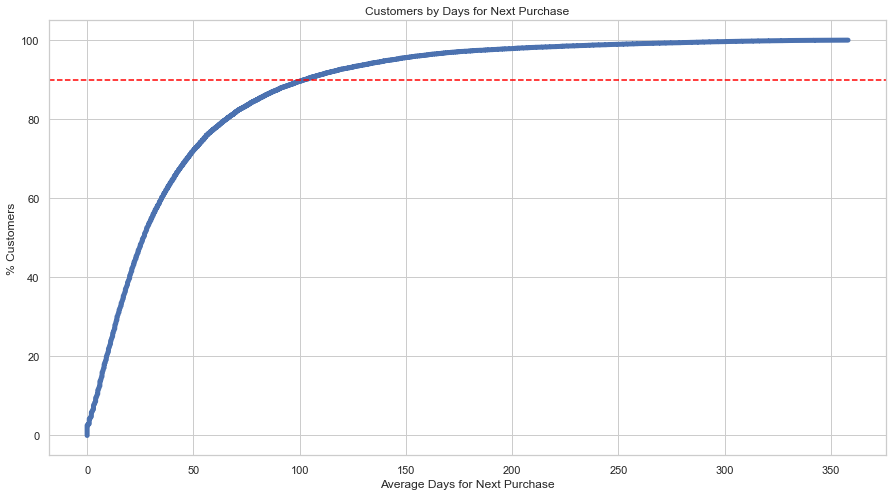

In [121]:
perc_cum = (np.arange(len(result)) + 1) / len(result) * 100

plt.plot(result['avg_days_repurchase'], perc_cum,  linewidth=5)
plt.axhline(y=90, color='red', linestyle='--', label='y=90')

plt.title('Customers by Days for Next Purchase')
plt.xlabel('Average Days for Next Purchase')
plt.ylabel('% Customers')
plt.grid(True)
plt.show()

In [83]:
result.loc[perc_cum >= 90, 'avg_days_repurchase'].iloc[0]

102.0

For 90% of customers, an average of less than 102 days pass for the next purchase.

We consider as **churners** those customers who exceed this threshold:

In [84]:
result['churn'] = (result['avg_days_repurchase'] > 102).astype(int)
result

,customer_id,avg_days_repurchase,churn
71507,934317,0.0,0
69310,851102,0.0,0
12051,134744,0.0,0
69315,851190,0.0,0
26862,332119,0.0,0
...,...,...,...
17175,206146,357.0,1
22280,275310,357.0,1
15978,189276,357.0,1
28344,349277,357.0,1


# Feature selection for Churn Prediction

Consider the following initial set of variables for churn prediction models:
- Gender
- Age
- Region
- Loyalty type
- Days from activation of the account
- Recency
- Monetary
- Whether the customer has ever made a return
- Whether the customer has ever made a review

In [124]:
merged_data_churn = (
    result[['customer_id', 'churn']]
    .merge(customer_reviews[['customer_id', 'yes_review']], on='customer_id', how='left')
    .fillna({'yes_review': 0})
    .astype({'yes_review': int})
    .merge(customers_addr[['customer_id', 'gender', 'age', 'region']], on='customer_id', how='left')
    .merge(customer_accounts[['customer_id', 'loyalty_type', 'days_from_activation']], on='customer_id', how='left')
    .merge(result_direction[['customer_id', 'yes_refund']], on='customer_id', how='left')
    .merge(rfm_pos[['customer_id', 'Recency', 'Monetary']], on='customer_id', how='inner')
)
merged_data_churn
# There are 94 fewer rows because of the negative monetary cases we have excluded
# --> I inserted inner join rather than left join to avoid null RFM values

,customer_id,churn,yes_review,gender,age,region,loyalty_type,days_from_activation,yes_refund,Recency,Monetary
0,934317,0,1,M,45,sicilia,standard,0,0,0,125.35
1,851102,0,1,F,38,campania,standard,56,0,22,96.17
2,134744,0,0,F,43,basilicata,business standard,467,0,217,135.25
3,851190,0,1,M,47,veneto,standard,55,1,49,0.00
4,332119,0,0,F,38,sicilia,standard,371,1,362,0.00
...,...,...,...,...,...,...,...,...,...,...,...
71409,206146,1,1,F,44,marche,premium,432,0,5,1.54
71410,275310,1,0,F,45,puglia,business standard,399,0,1,13.50
71411,189276,1,0,F,40,lombardia,standard,412,0,3,72.95
71412,349277,1,0,F,38,puglia,premium,362,0,3,16.89


In [125]:
merged_data_churn.isnull().sum()

customer_id               0
churn                     0
yes_review                0
gender                    0
age                       0
region                  990
loyalty_type              0
days_from_activation      0
yes_refund                0
Recency                   0
Monetary                  0
dtype: int64

We have 990 missing values for the Region, so let's remove the respective rows:

In [126]:
merged_data_churn = merged_data_churn.dropna(subset=['region'])

We use Pearson's correlation to check whether the numerical variables considered are too correlated with each other:

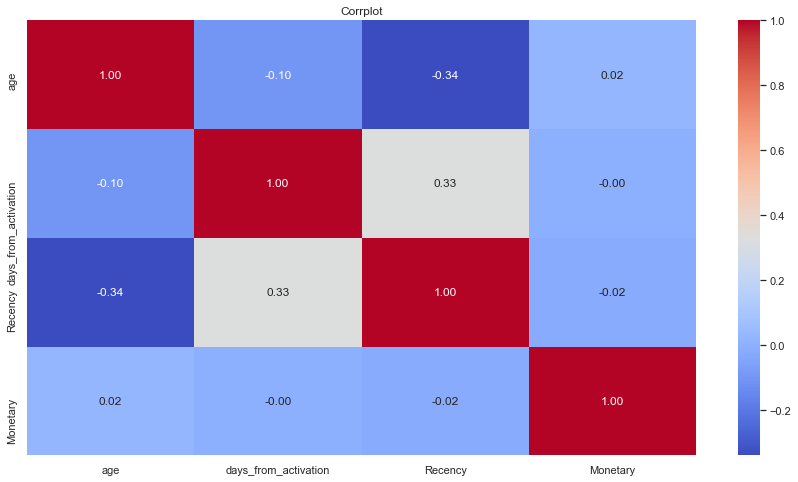

In [127]:
sns.set(style="white")
sns.heatmap(merged_data_churn[['age', 'days_from_activation', 'Recency', 'Monetary']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrplot")
plt.show()

No correlation is significantly high, so we do not remove any.

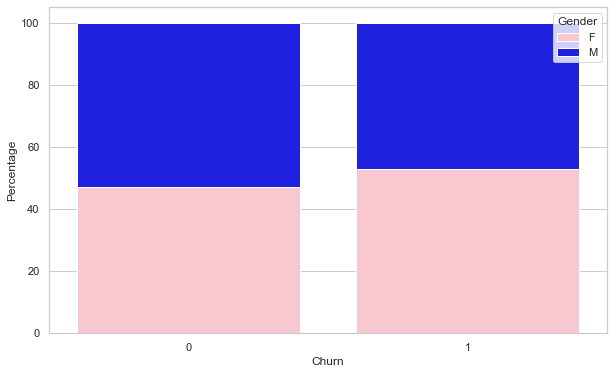

In [128]:
contingency_table = pd.crosstab(merged_data_churn['churn'], merged_data_churn['gender'])

contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=contingency_table_percentage.index, y=contingency_table_percentage[contingency_table_percentage.columns[0]],
                 color='pink', label=contingency_table_percentage.columns[0])
ax = sns.barplot(x=contingency_table_percentage.index, y=contingency_table_percentage[contingency_table_percentage.columns[1]],
                 color='blue', bottom=contingency_table_percentage[contingency_table_percentage.columns[0]], label=contingency_table_percentage.columns[1])

plt.xlabel('Churn')
plt.ylabel('Percentage')
plt.legend(title='Gender', loc='upper right')
plt.show()

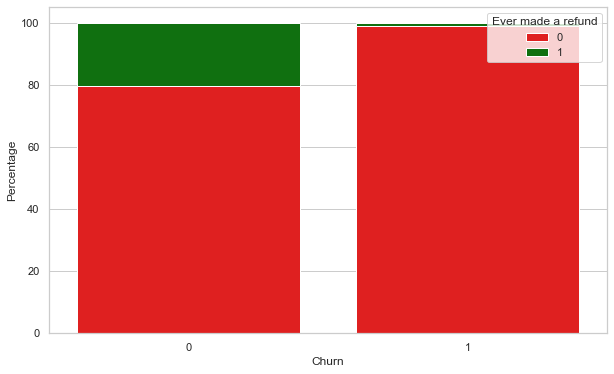

In [129]:
contingency_table = pd.crosstab(merged_data_churn['churn'], merged_data_churn['yes_refund'])

contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=contingency_table_percentage.index, y=contingency_table_percentage[contingency_table_percentage.columns[0]],
                 color='red', label=contingency_table_percentage.columns[0])
ax = sns.barplot(x=contingency_table_percentage.index, y=contingency_table_percentage[contingency_table_percentage.columns[1]],
                 color='green', bottom=contingency_table_percentage[contingency_table_percentage.columns[0]], label=contingency_table_percentage.columns[1])

plt.xlabel('Churn')
plt.ylabel('Percentage')
plt.legend(title='Ever made a refund', loc='upper right')
plt.show()

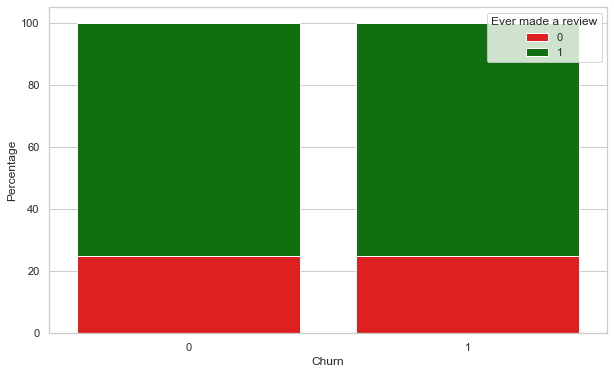

In [91]:
contingency_table = pd.crosstab(merged_data_churn['churn'], merged_data_churn['yes_review'])

contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=contingency_table_percentage.index, y=contingency_table_percentage[contingency_table_percentage.columns[0]],
                 color='red', label=contingency_table_percentage.columns[0])
ax = sns.barplot(x=contingency_table_percentage.index, y=contingency_table_percentage[contingency_table_percentage.columns[1]],
                 color='green', bottom=contingency_table_percentage[contingency_table_percentage.columns[0]], label=contingency_table_percentage.columns[1])

plt.xlabel('Churn')
plt.ylabel('Percentage')
plt.legend(title='Ever made a review', loc='upper right')
plt.show()

Let's perform one hot encoding for categorical variables:

In [92]:
merged_data_churn['gender_male'] = merged_data_churn['gender'].map({'M': 1, 'F': 0})
merged_data_churn = merged_data_churn.drop('gender', axis=1)

In [93]:
merged_data_churn_encoded = pd.get_dummies(merged_data_churn, columns=['region', 'loyalty_type'])
merged_data_churn_encoded

,customer_id,churn,yes_review,age,days_from_activation,yes_refund,Recency,Monetary,gender_male,region_abruzzo,...,region_sicilia,region_toscana,region_trentino alto adige,region_umbria,region_valle d'aosta,region_veneto,loyalty_type_business premium,loyalty_type_business standard,loyalty_type_premium,loyalty_type_standard
0,934317,0,1,45,0,0,0,125.35,1,0,...,1,0,0,0,0,0,0,0,0,1
1,851102,0,1,38,56,0,22,96.17,0,0,...,0,0,0,0,0,0,0,0,0,1
2,134744,0,0,43,467,0,217,135.25,0,0,...,0,0,0,0,0,0,0,1,0,0
3,851190,0,1,47,55,1,49,0.00,1,0,...,0,0,0,0,0,1,0,0,0,1
4,332119,0,0,38,371,1,362,0.00,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71409,206146,1,1,44,432,0,5,1.54,0,0,...,0,0,0,0,0,0,0,0,1,0
71410,275310,1,0,45,399,0,1,13.50,0,0,...,0,0,0,0,0,0,0,1,0,0
71411,189276,1,0,40,412,0,3,72.95,0,0,...,0,0,0,0,0,0,0,0,0,1
71412,349277,1,0,38,362,0,3,16.89,0,0,...,0,0,0,0,0,0,0,0,1,0


In [94]:
merged_data_churn_encoded.shape

(70424, 33)

Final dataset has 70,424 rows and 33 variables.

### Export cleaned data

In [95]:
merged_data_churn_encoded.to_csv('churn.csv', index=False)

# Feature selection for Repurchase Propensity model

Let's perform same operations on the same variables for repurchase propensity model:

In [130]:
merged_data_rep = (
    rfm_pos[['customer_id', 'Recency', 'Monetary', 'oneshooter']]
    .merge(customer_reviews[['customer_id', 'yes_review']], on='customer_id', how='left')
    .fillna({'yes_review': 0})
    .astype({'yes_review': int})
    .merge(customers_addr[['customer_id', 'gender', 'age', 'region']], on='customer_id', how='left')
    .merge(customer_accounts[['customer_id', 'loyalty_type', 'days_from_activation']], on='customer_id', how='left')
    .merge(result_direction[['customer_id', 'yes_refund']], on='customer_id', how='left')
)
merged_data_rep

,customer_id,Recency,Monetary,oneshooter,yes_review,gender,age,region,loyalty_type,days_from_activation,yes_refund
0,23,69,483.51,0,1,F,44,lombardia,standard,234,1
1,30,281,10179.56,0,0,F,44,lombardia,premium,323,0
2,32,28,58.85,0,1,M,34,lombardia,business premium,46,0
3,48,0,1053.62,0,0,M,68,lombardia,premium,265,1
4,50,70,28.75,0,1,F,43,lombardia,premium,158,0
...,...,...,...,...,...,...,...,...,...,...,...
104028,934484,0,39.10,1,1,F,43,lombardia,standard,0,0
104029,934581,0,33.60,1,1,M,43,lazio,standard,0,0
104030,934620,0,21.98,1,1,F,59,veneto,standard,0,0
104031,934660,0,1.90,1,1,F,43,puglia,standard,0,0


In [97]:
merged_data_rep.isnull().sum()

customer_id                0
Recency                    0
Monetary                   0
oneshooter                 0
yes_review                 0
gender                     0
age                        0
region                  1664
loyalty_type               0
days_from_activation       0
yes_refund                 0
dtype: int64

Here again, we have missing values for the Region (1664) and remove the respective rows:

In [131]:
merged_data_rep = merged_data_rep.dropna(subset=['region'])

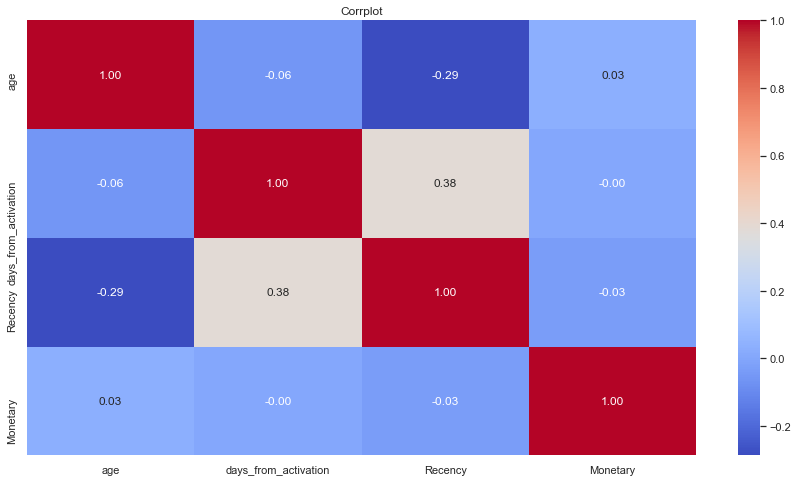

In [132]:
sns.set(style="white")
sns.heatmap(merged_data_rep[['age', 'days_from_activation', 'Recency', 'Monetary']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrplot")
plt.show()

In [133]:
merged_data_rep['gender_male'] = merged_data_rep['gender'].map({'M': 1, 'F': 0})
merged_data_rep = merged_data_rep.drop('gender', axis=1)

In [134]:
merged_data_rep_encoded = pd.get_dummies(merged_data_rep, columns=['region', 'loyalty_type'])
merged_data_rep_encoded

,customer_id,Recency,Monetary,oneshooter,yes_review,age,days_from_activation,yes_refund,gender_male,region_abruzzo,...,region_sicilia,region_toscana,region_trentino alto adige,region_umbria,region_valle d'aosta,region_veneto,loyalty_type_business premium,loyalty_type_business standard,loyalty_type_premium,loyalty_type_standard
0,23,69,483.51,0,1,44,234,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,30,281,10179.56,0,0,44,323,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,32,28,58.85,0,1,34,46,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,48,0,1053.62,0,0,68,265,1,1,0,...,0,0,0,0,0,0,0,0,1,0
4,50,70,28.75,0,1,43,158,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104028,934484,0,39.10,1,1,43,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
104029,934581,0,33.60,1,1,43,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
104030,934620,0,21.98,1,1,59,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
104031,934660,0,1.90,1,1,43,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Final dataset has 102,369 rows and 33 variables.

### Export cleaned data

In [101]:
merged_data_rep_encoded.to_csv('repurchase.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fad4abbb-8bc7-4ee9-9f5c-63fc95d85e92' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>